In [2]:
import torch
import torch.nn.functional as F

In [ ]:
bs = 3
a = torch.zeros(bs,10, dtype=torch.int64)
# a = torch.arange(10*bs, dtype=torch.int64).view(bs,10)
pos_start = torch.randint(0,5,(bs,1))
pos_end = torch.randint(6,10,(bs,1))
a = a.scatter(1, pos_start, -1)
a = a.scatter(1, pos_end, -2)
a[1,:] = 0
a[1,-1] = -2
a[1,-2] = -1
a

In [4]:
# exclude = (a == -1) | (a == -2)
# b = torch.randn(bs,10,5)
# bs, ts, fs = b.shape
# b[~exclude].view(bs, ts-2, fs)

In [ ]:
start_tokens = torch.where(a == -1)[1]
end_tokens = torch.where(a == -2)[1]
# start_tokens, end_tokens
vector_length = end_tokens - start_tokens -1
vector_length

In [ ]:
def aggregate_temporal_features(vectors, num_vectors):
    assert len(vectors.size()) == 3
    interpolated_vectors = torch.nn.functional.interpolate(
        torch.swapaxes(vectors, 1, 2),
        size=num_vectors,
        mode="linear",
        align_corners=True,
    )
    interpolated_vectors = torch.swapaxes(interpolated_vectors, 1, 2)
    assert interpolated_vectors.size()[1] == num_vectors
    return interpolated_vectors

vectors = torch.rand(bs, 3, 5)
embeds = torch.ones(bs, 10, 5)

# aggregate_temporal_features(embeds, 2).shape

aggregated = []
for i, l in enumerate(vector_length):
    print(l)
    if l == 0:
        aggregated.append(torch.zeros(embeds.size(1), embeds.size(2)))
        continue
    agg = aggregate_temporal_features(vectors[None,i], l)
    agg = F.pad(agg, (0, 0, start_tokens[i]+1, embeds.size(1)-start_tokens[i]-l-1), "constant", 0)
    aggregated.append(agg[0])

aggregated = torch.stack(aggregated)
print(aggregated[1])


In [ ]:
embeds + aggregated

In [ ]:
aggregated.shape

In [ ]:
import torch

torch.random.manual_seed(0)
a = torch.normal(1, 1, (3, 10, 5))
b = aggregated

torch.norm(a, dim=2, keepdim=True).shape

c = a + b
c = (c / (torch.norm(c, dim=2, keepdim=True) + 1e-6)) * torch.norm(a, dim=2, keepdim=True)

print(torch.norm(a))
print(torch.norm(c))
a[0], c[0], b[0]

In [ ]:
import torch
import torch.nn as nn
from peft import LoraConfig, get_peft_model


class SimpleNet(nn.Module):
	def __init__(self):
		super(SimpleNet, self).__init__()
		self.fc1 = nn.Linear(10, 5)
		self.fc2 = nn.Linear(5, 2)
	
	def forward(self, x):
		x = torch.relu(self.fc1(x))
		x = self.fc2(x)
		return x
	
	# def state_dict(self, include_fc1=True, include_fc2=True, **kwargs):
	# 	# Get the original state_dict
	# 	original_state_dict = super(SimpleNet, self).state_dict(**kwargs)
		
	# 	# Filter the state_dict based on custom parameters
	# 	filtered_state_dict = {}
	# 	if include_fc1:
	# 		filtered_state_dict.update({k: v for k, v in original_state_dict.items() if 'fc1' in k})
	# 	if include_fc2:
	# 		filtered_state_dict.update({k: v for k, v in original_state_dict.items() if 'fc2' in k})
		
	# 	# Add custom information
	# 	custom_info = {'custom_info': 'This is a custom state dict'}
		
	# 	# Combine the filtered state_dict with custom information
	# 	combined_state_dict = {**filtered_state_dict, **custom_info}
		
	# 	return combined_state_dict

# Function to apply LoRA adapter
def apply_lora_adapter(model):
	lora_config = LoraConfig(
		r=4,  # Rank of the low-rank approximation
		lora_alpha=32,  # Scaling factor
		lora_dropout=0.1,  # Dropout rate
		target_modules=['fc1', 'fc2']  # Target modules to apply LoRA
	)
	lora_model = get_peft_model(model, lora_config)
	
	# Override the state_dict method to forward additional parameters
	# def lora_state_dict(self, include_fc1=True, include_fc2=True, **kwargs):
	# 	return self.model.state_dict(include_fc1=include_fc1, include_fc2=include_fc2, **kwargs)
	
	# lora_model.state_dict = lora_state_dict.__get__(lora_model, type(lora_model))
	
	return lora_model

# Example usage
model = SimpleNet()
# model_with_lora = apply_lora_adapter(model)
sd = model.state_dict()
sd["fc1.weight"]

In [ ]:
x = torch.load("/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/merge/interpolate/iemocap/LLaMA2-base/audio_upscale_10/stage_2/best_model.pth")
x

In [ ]:
import torch
torch.random.manual_seed(0)
a = torch.randn(3,4, requires_grad=True)
b = torch.randn(3,4, requires_grad=True)
s = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
# s = torch.tensor(1.0, requires_grad=True)

x = a + b * s
x = (x / x.norm(dim=1, keepdim=True)) * a.norm(dim=1, keepdim=True)

x.sum().backward()

print(a.grad) 
print(b.grad)
print(s.grad)


In [7]:
import torch
import torch.nn as nn
from torch.optim import AdamW

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)
        self.scale = nn.Parameter(torch.tensor(2.0))

        # self.scale.register_post_accumulate_grad_hook(lambda p: print(p))
    
    def forward(self, x):
        x1, x2 = x
        scaled_x2 = x2 * self.scale
        added = x1 + scaled_x2
        out = (added / added.norm(dim=1, keepdim=True)) * x1.norm(dim=1, keepdim=True)
        out = self.fc1(out)
        out = torch.sigmoid(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out


In [ ]:
import torch
torch.random.manual_seed(0)

# X1 = torch.randn(4, 2)
x = torch.tensor([[-1.0, -1.0], [-1.0, 1.0], [1.0, -1.0], [1.0, 1.0]])
y = torch.tensor([[0.0], [1.0], [1.0], [0.0]])

model = Model()
# a = model((X1, X2))
# print(X1.norm(dim=1, keepdim=True))
# print(a.norm(dim=1, keepdim=True))

# print(X1)
# print(a)


optimizer = AdamW(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

for i in range(1000):
    noise = torch.normal(0, 1, (4,2))
    y_pred = model((x, noise))
    nllloss = loss_fn(y_pred, y)
    if i % 1000 == 0:
        print(nllloss.item())
    optimizer.zero_grad()
    nllloss.backward()
    optimizer.step()

model((x, torch.normal(0, 0.2, (4,2))))

In [ ]:
for n, p in model.named_parameters():
    print(n, p)

In [ ]:
# with torch.no_grad():
a = model((x, torch.normal(0, 0.2, (4,2))))
nllloss = loss_fn(a, y)
nllloss.backward()
print(model.scale.grad)

In [ ]:
from transformers import LlamaForCausalLM, LlamaTokenizer

llama = LlamaForCausalLM.from_pretrained("/home/fock/code/MultiModalInstructERC/models/language/LLaMA2-base")
tokenizer = LlamaTokenizer.from_pretrained("/home/fock/code/MultiModalInstructERC/models/language/LLaMA2-base")

In [ ]:
tokenizer.pad_token_id = tokenizer.bos_token_id
tokenizer.padding_side = "left"

inputs = tokenizer(["hello", "second hello"], return_tensors="pt", padding=True)
# print(inputs)
a = llama(**inputs, output_hidden_states=True)
# b = torch.rand_like(a.logits)
# # torch.cat([a.logits, b], dim=-1).shape
# print(torch.argmax(a.logits, dim=-1))
# print(torch.argmax(torch.softmax(a.logits, dim=-1), dim=-1))
print(a.hidden_states[0].shape)

In [ ]:
import torch.nn as nn
nllloss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
input, target

In [ ]:
import math
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import AdamW
from accelerate import Accelerator

acc = Accelerator(gradient_accumulation_steps=100)


def get_scheduler(
    optimizer,
    len_dataset,
    batch_size,
    gradient_accumulation_steps,
    epochs,
    min_lr_frac=0.5,
):
    num_steps = math.ceil(len_dataset / batch_size)
    num_steps *= epochs
    warmup_steps = math.ceil(num_steps * 0.1)

    def cosine_decay_with_warmup(step):
        if step < warmup_steps:
            return float(step) / max(1.0, warmup_steps)

        progress = float(step - warmup_steps) / max(1, num_steps - warmup_steps)
        cos_progress = 0.5 * (1 + math.cos(math.pi * progress))
        return cos_progress + (1 - cos_progress) * min_lr_frac

    scheduler = LambdaLR(optimizer, lr_lambda=cosine_decay_with_warmup)

    return scheduler

model = Model()
optimizer = AdamW(model.parameters(), lr=1)
lr_scheduler = get_scheduler(
    optimizer,
    10000,
    10,
    1,
    10,
    min_lr_frac=0.5,
)


lrs = []
for epoch in range(10):
    for batch in range(10000 // 10):
        with acc.accumulate(model):
            lr_scheduler.step()
            lrs.extend(lr_scheduler.get_last_lr())

import matplotlib.pyplot as plt
plt.plot(lrs)
plt.show()

In [ ]:
import pickle
with open("/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/merge/interpolate/iemocap/LLaMA2-base/audio_upscale_10/stage_1/lrs1.pkl", "rb") as f:
    lrs1 = pickle.load(f)

with open("/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/merge/interpolate/iemocap/LLaMA2-base/audio_upscale_10/stage_1/lrs2.pkl", "rb") as f:
    lrs2 = pickle.load(f)

plt.plot(lrs1)
plt.plot(lrs2)	
plt.show()

1.5223163281168257 13


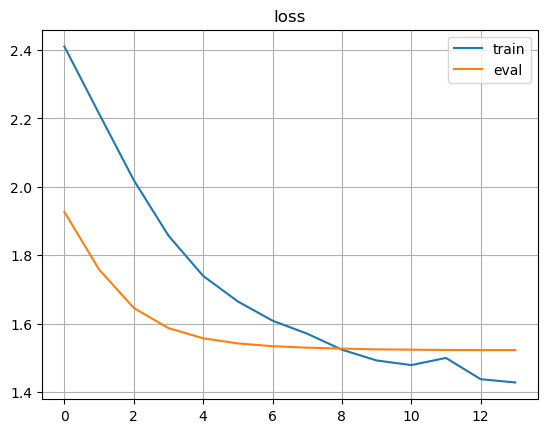

0.7765071724582775 13


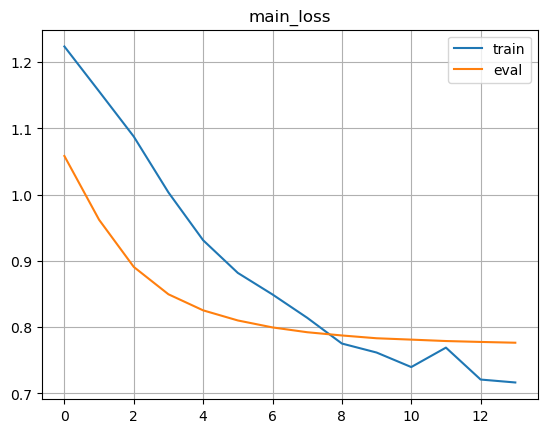

0.7316113020398934 4


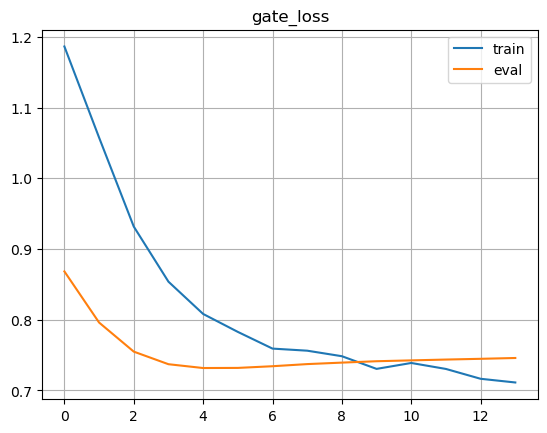

0.8168840580826322 0


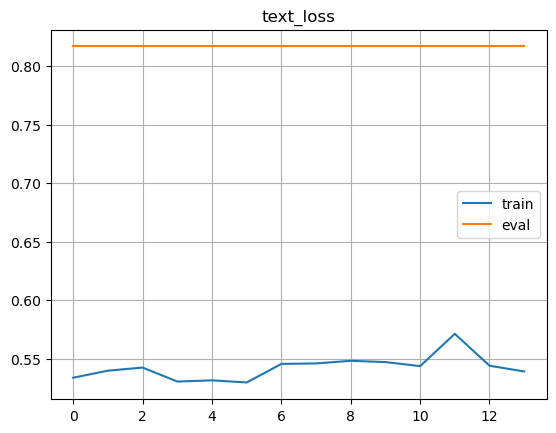

1.2585283227154773 0


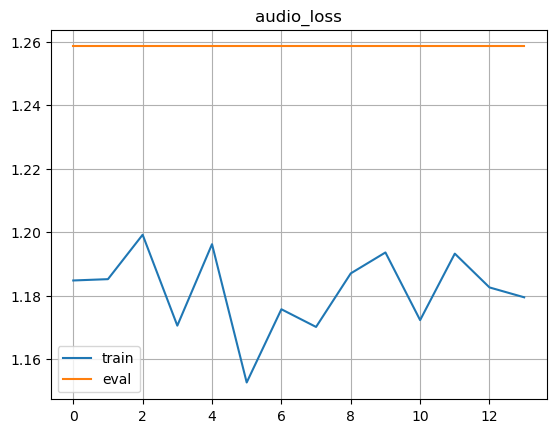

In [18]:
p = "experiments/multimodal/late_fusion/final/iemocap/LLaMA2-base/final_4/stage_3"
import json
import os
import matplotlib.pyplot as plt

t_losses = list[dict[str, float]]

with open(os.path.join(p, "train_losses.json")) as f:
    train_losses:t_losses = json.load(f)

with open(os.path.join(p, "eval_losses.json")) as f:
    eval_losses:t_losses = json.load(f)

def get_losses(loss_dict:t_losses, key:str):
    return [loss[key] for loss in loss_dict]

# loss_name = "audio_loss"



for loss_name in train_losses[0].keys():
    _train_losses = get_losses(train_losses, loss_name)
    _eval_losses = get_losses(eval_losses, loss_name)
    print(min(_eval_losses), _eval_losses.index(min(_eval_losses)))
    plt.plot(_train_losses)
    plt.plot(_eval_losses)
    plt.grid(True)
    plt.title(loss_name)
    plt.legend(["train", "eval"])
    plt.show()


In [20]:
import torch
loss_fn = torch.nn.MSELoss()

a = torch.rand(8, 2)
b = a
print(a)
loss = loss_fn(a, b)
loss

a.tolist()

tensor([[0.8496, 0.6192],
        [0.0780, 0.1709],
        [0.6900, 0.7887],
        [0.1512, 0.3968],
        [0.5798, 0.8105],
        [0.1125, 0.7564],
        [0.5286, 0.5044],
        [0.6180, 0.2913]])


[[0.8495653867721558, 0.6191512942314148],
 [0.07795286178588867, 0.17094510793685913],
 [0.6899776458740234, 0.7887442111968994],
 [0.15120470523834229, 0.3967589735984802],
 [0.5798315405845642, 0.8105452656745911],
 [0.11245429515838623, 0.7564308643341064],
 [0.5286198854446411, 0.5043877363204956],
 [0.6179515719413757, 0.2912943363189697]]

In [7]:
import torch
p = "experiments/multimodal/late_fusion/final/iemocap/LLaMA2-base/final_4/stage_3/best_model.pth"
x = torch.load(p, map_location="cpu")
keys = [k for k in x.keys() if "adapter" in k]

for k in keys:
    del x[k]

torch.save(x, p)


In [17]:
from utils.model import SequenceClassifierOutput

o = SequenceClassifierOutput(logits=torch.randn(8, 5))
o.__dict__

{'logits': tensor([[ 1.6867,  1.0424, -1.1274, -0.7243, -0.6701],
         [ 0.0107,  0.0803, -0.5261,  0.9672,  0.2951],
         [-1.5599, -0.3873,  0.3293,  0.6861, -0.2419],
         [-0.7683,  0.3649,  1.7521, -0.7705, -1.5282],
         [ 3.1649, -1.0460, -0.0995,  0.1159, -0.2027],
         [-0.7688,  0.9857,  0.9978,  0.5479,  1.1052],
         [ 0.1438, -0.7431,  0.4642,  1.6308, -0.0874],
         [-0.7186, -0.9027, -0.0984, -0.8332,  0.1330]]),
 'loss': None,
 'hidden_states': None,
 'attentions': None,
 'text_loss': None,
 'audio_loss': None,
 'gate_loss': None,
 'main_loss': None}

In [15]:
from pytorch_metric_learning import distances
import torch

loss = distances.CosineSimilarity()
x1 = torch.randn(8, 128)
x2 = torch.randn(8, 128)
labels = torch.randint(0, 3, (8,))

loss(x1, x1)
# torch.cat([x1, x2], dim=0).shape

tensor([[ 1.0000e+00, -9.9454e-02,  6.1557e-02, -1.0912e-02,  1.2086e-01,
         -7.3180e-02, -2.8667e-02, -7.9728e-02],
        [-9.9454e-02,  1.0000e+00,  9.1030e-03, -1.0169e-02, -7.6664e-02,
         -6.4474e-02,  6.9024e-03,  4.4008e-02],
        [ 6.1557e-02,  9.1030e-03,  1.0000e+00, -1.6393e-01, -3.2175e-02,
          3.5205e-04,  5.0895e-02, -1.1088e-01],
        [-1.0912e-02, -1.0169e-02, -1.6393e-01,  1.0000e+00,  7.1371e-03,
          1.7387e-01, -3.1587e-02,  1.5538e-02],
        [ 1.2086e-01, -7.6664e-02, -3.2175e-02,  7.1371e-03,  1.0000e+00,
          6.5425e-02, -1.2190e-02,  1.0475e-01],
        [-7.3180e-02, -6.4474e-02,  3.5205e-04,  1.7387e-01,  6.5425e-02,
          1.0000e+00, -9.7837e-02, -1.0113e-01],
        [-2.8667e-02,  6.9024e-03,  5.0895e-02, -3.1587e-02, -1.2190e-02,
         -9.7837e-02,  1.0000e+00,  9.8412e-02],
        [-7.9728e-02,  4.4008e-02, -1.1088e-01,  1.5538e-02,  1.0475e-01,
         -1.0113e-01,  9.8412e-02,  1.0000e+00]])

In [10]:
import torch

a = torch.randn(3, 6)
torch.softmax(a, dim=1).sum(1)

tensor([1.0000, 1.0000, 1.0000])

In [6]:
import torch

a = torch.randn(1, 5, 10)
b = torch.randn(1, 5, 10)
b[0, 0:2, :] = 0
b[0, 4:5, :] = 0

mask = torch.ones_like(a, dtype=torch.float)
mask[torch.where(b)] = 0.5
mask

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
          0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
          0.5000, 0.5000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000]]])

In [ ]:
import numpy as np
np.random.seed(2)
a = np.random.randint(0, 2, (5,)) 
b = a.copy()
b[0] = 1 
loss_weights = np.ones((5,)) + (a * 0.3 + b * 0.5)
loss_weights[loss_weights == 1.0] = 0.7
loss_weights

In [ ]:
p = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/late_fusion/iemocap/LLaMA2-base/linear/add_aux/stage_2"
import torch

state_dict = torch.load(os.path.join(p, "best_model.pth"))
print(state_dict["classifier.weight"])
state_dict["classifier.weight"] = (
        state_dict["text_projector.classifier.weight"]
        + state_dict["audio_projector.classifier.weight"]
    ) / 2
print(state_dict["classifier.weight"])

In [40]:
a = torch.randn(5,2)
a.softmax(dim=1), torch.sigmoid(a) / torch.sigmoid(a).sum(dim=1, keepdim=True)
# scale a between [0,1]
a = (a - a.min(dim=1, keepdim=True)[0]) / (a.max(dim=1, keepdim=True)[0] - a.min(dim=1, keepdim=True)[0])
a

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])

In [56]:
text_only_p = "experiments/multimodal/late_fusion/final/iemocap/LLaMA2-base/final_version/stage_3_709/preds_test.json"

import json
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score

with open(text_only_p, "rt") as f:
    text_only = json.load(f)
# print(text_only[0])
df = pd.DataFrame.from_records(text_only)
df["correct"] = (df["target"] == df["output"]).astype(int)

f1_score(df["target"], df["output"], average="weighted")


0.7090979054166279

In [10]:
p = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/late_fusion/final/iemocap/LLaMA2-base/final_version/stage_2/best_model.pth"
d = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/late_fusion/final/iemocap/LLaMA2-base/final_version_3/stage_2/best_model.pth"

import torch

state_dict_p:dict[str, torch.Tensor] = torch.load(p)
state_dict_d:dict[str, torch.Tensor] = torch.load(d)

for k, v in state_dict_p.items():
    if "text_projector" in k:
        _, layer = k.split(".", 1)
        state_dict_d[f"text_classifier.{layer}"] = state_dict_p[k]

torch.save(state_dict_d, d)

: 

In [ ]:
text_only_p = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/late_fusion/final/iemocap/LLaMA2-base/final_version/stage_2"
audio_only_p = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/late_fusion/iemocap/LLaMA2-base/linear/mha_gate_add/stage_1/preds_test_no_text.json"
both_p = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/late_fusion/iemocap/LLaMA2-base/linear/mha_gate_add/stage_2/preds_test.json"

import json
import pandas as pd

with open(text_only_p, "rt") as f:
    text_only = json.load(f)

with open(audio_only_p, "rt") as f:
    audio_only = json.load(f)

with open(both_p, "rt") as f:
    both = json.load(f)

results = pd.DataFrame.from_records(text_only, index=["index"]).merge(
    pd.DataFrame.from_records(audio_only, index=["index", "input", "target"]),
    on=["index"],
    suffixes=["_text", "_audio"],
).merge(pd.DataFrame.from_records(both, index=["index", "input", "target"]), on=["index"], suffixes=["_both"])
assert len(results) == len(text_only)
results

In [ ]:
results["utterance"] = results["input"].str.extract("<Speaker_\d: \"(.*?)\">")
audio_or_text_true = results[(results["output_text"] == results["target"]) | (results["output_audio"] == results["target"])]
audio_or_text_true

In [ ]:
results["any_correct"] = results[(results["output_text"] == results["target"]) | (results["output_audio"] == results["target"])]["target"]
results.loc[results["any_correct"].isna(), "any_correct"] = results.loc[results["any_correct"].isna(), "output_text"]

from sklearn.metrics import f1_score

f1_score(results["target"], results["any_correct"], average="weighted")

In [ ]:
results["max_cert_correct"] = results[results["certainty_audio"] > results["certainty_text"]]["output_audio"]
results.loc[results["max_cert_correct"].isna(), "max_cert_correct"] = results.loc[results["max_cert_correct"].isna(), "output_text"]

print(len(results[results["max_cert_correct"] == results["target"]]))
print(len(results[results["any_correct"] == results["target"]]))
print(len(results[results["output"] == results["target"]]))

In [1]:
import torch

w = torch.randn(10, 2, requires_grad=True)
x = torch.ones(10, 1)
x[:5, :] = 0
o = torch.matmul(x.T,w)
y = torch.zeros((1, 2))

loss_fn = torch.nn.MSELoss()
nllloss = loss_fn(o, y)

w.register_hook(lambda grad: print(grad))

nllloss.backward()
w.grad

tensor([[-0.0000,  0.0000],
        [-0.0000,  0.0000],
        [-0.0000,  0.0000],
        [-0.0000,  0.0000],
        [-0.0000,  0.0000],
        [-0.3465,  3.4202],
        [-0.3465,  3.4202],
        [-0.3465,  3.4202],
        [-0.3465,  3.4202],
        [-0.3465,  3.4202]])


tensor([[-0.0000,  0.0000],
        [-0.0000,  0.0000],
        [-0.0000,  0.0000],
        [-0.0000,  0.0000],
        [-0.0000,  0.0000],
        [-0.3465,  3.4202],
        [-0.3465,  3.4202],
        [-0.3465,  3.4202],
        [-0.3465,  3.4202],
        [-0.3465,  3.4202]])

In [ ]:
import numpy as np
print(np.mean(np.diff(eval_losses[-4:])))
print(np.mean(np.diff(train_losses[-3:])))

In [ ]:
import torch

x = torch.load("experiments/multimodal/concat/iemocap/LLaMA2-base/mlp/audio_instruction/stage_1/best_model.pth", map_location="cpu")

x


In [ ]:
p = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/late_fusion/iemocap/LLaMA2-base/text_only/stage_3/preds_test.json"
import json

with open(p) as f:
    preds = json.load(f)

from sklearn.metrics import f1_score
targets = [x["target"] for x in preds]
outputs = [x["output"] for x in preds]

f1_score(targets, outputs, average="weighted", labels=["angry", "excited", "frustrated", "happy", "neutral", "sad"])

In [ ]:
from pytorch_metric_learning import losses
torch.random.manual_seed(0)
nllloss = losses.NTXentLoss()
x = torch.randn(8, 10)
y = torch.randint(0, 5, (8,))
# x[y == 4] = 1

nllloss(x, y)

In [ ]:
import torch
import torch.nn as nn

mha = nn.MultiheadAttention(10, 2, batch_first=True)
gate = nn.Linear(10, 1)
x = torch.randn(1, 8, 10)
att, att_weights =mha(x, x, x)
gate(torch.mean(att, dim=1))

In [ ]:
import torch.nn as nn
import torch
torch.random.manual_seed(0)

x1 = torch.randn(4, 3)
x2 = torch.randn(4, 3)
y = torch.randint(0, 3, (4,))

x1[0,0] = 20
y[0] = 0


# nllloss = nn.NLLLoss(reduction="none")
# celoss = nn.CrossEntropyLoss(reduction="none")

# print(celoss(x, y))
# print(nllloss(torch.log_softmax(x, dim=1), y))
x1_prob, x2_prob = torch.softmax(x1, dim=1), torch.softmax(x2, dim=1)
x1_pred, x2_pred = torch.argmax(x1_prob, dim=1, keepdim=False), torch.argmax(x2_prob, dim=1, keepdim=False)

x1_correct, x2_correct = (x1_pred == y).float(), (x2_pred == y).float()
torch.stack([x1_correct, x2_correct], dim=1)

In [ ]:
torch.random.manual_seed(0)
y = torch.randint(0, 2, (4,2)).float()
y_pred = torch.rand(4, 2)
weights = torch.zeros_like(y) + torch.stack([torch.zeros(y.shape[0]), y[:,1]], dim=1)
bce = nn.BCEWithLogitsLoss(pos_weight=weights)
bce(y_pred, y)

In [ ]:
import torch

torch.random.manual_seed(0)

a = torch.randn(4, 3, requires_grad=True)
b = torch.randn(4, 3, requires_grad=True)
c = torch.randn(4, 3, requires_grad=True)

loss_fn = nn.MSELoss()
loss1 = loss_fn(a, b)
loss2 = loss_fn(a, c)

loss = loss1 + loss2
loss.backward()

print(a.grad[[0,2]])

In [4]:
def print_trainable_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.shape)

In [ ]:
from transformers import AutoModelForCausalLM, AutoConfig
import os
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# llm_config = AutoConfig.from_pretrained(os.path.abspath("models/language/LLaMA2-base"))
llm = AutoModelForCausalLM.from_pretrained(os.path.abspath("models/language/LLaMA2-base"))
# llm_config.num_hidden_layers = 16
# llm = AutoModelForCausalLM.from_config(llm_config)
# llm.from_pretrained(os.path.abspath("models/language/LLaMA2-base"))


peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.0,
    # target_modules=".*\.([0-9]|1[0-6])\..*([qkvo]_proj).*",
    # target_modules=".*([qkvo]_proj).*",
    target_modules=".*\.([0-9]|1[0-6])\..*([qkvo]_proj|mlp\..*?_proj).*",
    bias="none",
)
model = get_peft_model(llm, peft_config)

model.print_trainable_parameters()

In [ ]:
type(model)

In [ ]:
import torch
p = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/late_fusion/iemocap/LLaMA2-base/linear/add_aux_lossgate_bce/stage_3_715/best_model.pth"
sd = torch.load(p, map_location="cpu")
print(sd.keys())
# sd = {k:v for k,v in sd.items() if "projector" in k}
# torch.save(sd, "experiments/multimodal/late_fusion/iemocap/LLaMA2-base/linear/simple_gate/best_model.pth")

In [9]:
from sklearn.metrics import f1_score
import json

with open("/home/fock/code/MultiModalInstructERC/experiments/multimodal/late_fusion/iemocap/LLaMA2-base/linear/simple_gate/stage_1/preds_test_no_audio.json", "rt") as f:
    preds = json.load(f)

targets = list(set([x["target"] for x in preds]))
print(targets)

f1_score([x["target"] for x in preds], [x["output"] for x in preds], average="weighted")


['neutral', 'sad', 'frustrated', 'happy', 'excited', 'angry']


0.6923523053584558

In [17]:
x = torch.randn(4, 3)

from functools import partial

def min_max_rescale(x:torch.Tensor):
    g = lambda f: partial(f, dim=1, keepdims=True)
    f = lambda h, x: g(h)(x).values 
    return (x - f(torch.min, x)) / (f(torch.max, x) - f(torch.min, x))

min_max_rescale(x)

tensor([[0.7852, 1.0000, 0.0000],
        [0.6149, 0.0000, 1.0000],
        [0.9218, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.1152]])

In [12]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

x = np.ones((1000,))

w = sliding_window_view(x, (2,))
w[::2].shape

(500, 2)

In [19]:
def calculate_receptive_field(kernel_sizes, strides):
    """
    Calculate the receptive field of a 1D CNN.

    Parameters:
        kernel_sizes (list): A list of kernel sizes for each layer.
        strides (list): A list of strides for each layer.

    Returns:
        int: The total receptive field size.
    """
    receptive_field = 1  # Initial receptive field size
    total_stride = 1  # Initial total stride size

    for kernel_size, stride in zip(kernel_sizes, strides):
        receptive_field += (kernel_size - 1) * total_stride
        total_stride *= stride

    return receptive_field


def calculate_output_size(input_size, kernel_sizes, strides):
    """
    Calculate the output size after a sequence is passed through a 1D CNN.

    Parameters:
    - input_size (int): The initial length of the input sequence.
    - kernel_sizes (list): A list of integers representing the kernel size of each layer.
    - strides (list): A list of integers representing the stride of each layer.

    Returns:
    - final_output_size (int): The final size of the sequence after all layers.
    - size_reduction (int): By how much the sequence has been shortened.
    """
    
    output_size = input_size
    
    # Iterate through each layer
    for kernel_size, stride in zip(kernel_sizes, strides):
        output_size = (output_size - (kernel_size - 1)) // stride + 1

    # Calculate the size reduction
    size_reduction = input_size - output_size
    
    return output_size, size_reduction

# Example usage:
input_size = 16000  # Length of the input sequence
# Example usage
kernel_sizes = [10, 3, 3, 3, 3, 2, 2]
strides = [5, 2, 2, 2, 2, 2, 2]
for i in range(1, len(kernel_sizes)+1):
    receptive_field = calculate_receptive_field(kernel_sizes[:i], strides[:i])
    print(f"The receptive field is: {receptive_field}")

output_length = calculate_output_size(input_size, kernel_sizes, strides)
print(f"The output length is: {output_length}")


The receptive field is: 10
The receptive field is: 20
The receptive field is: 40
The receptive field is: 80
The receptive field is: 160
The receptive field is: 240
The receptive field is: 400
The output length is: (50, 15950)


In [20]:
output_length[0] / input_size

0.003125

In [19]:
import torch
import torch.nn as nn

text = torch.randn(10, 5)
audio = torch.randn(10, 5)
alpha = torch.tensor(0.5, requires_grad=True)
beta = torch.tensor(0.5, requires_grad=True)

audio[:3, :] = 0
audio[6:, :] = 0

mask = torch.ones_like(text)
mask[audio.abs().sum(dim=1) > 0] = alpha * 0.5
o = text * mask + audio * beta



TypeError: argument 0 is not a Variable